In [1]:
#%matplotlib inline

import numpy as np
import itertools
import random
import math
import matplotlib.pyplot as plt
import tqdm

import import_ipynb
from rules import Game
from players import RandomPlayer, GreedyPlayer, MCTSPlayer, UCTPlayer, GreedyUCTPlayer, HumanPlayer

np.set_printoptions(edgeitems=12)

importing Jupyter notebook from rules.ipynb
importing Jupyter notebook from players.ipynb


# Generate a dataset

We play with our best player (GreedyUCTPlayer) and use the real game states to fill our datasets.

If the features are the board and the value to learn is the ratio of wins, we will learn nothing : it depends a lot on the score.

If we add the score, we will might then learn that a high score leads to a great ratio of wins, not very interesting. (Or it might not, since the hypothesis "high score leads to a great ratio of wins" is the hypothesis of the greedy agent).

We will thus try to learn with X as the game state and Y the probabilities of wins for each move.

`play_game()` plays a full game between two opponents and return the end state.

In [2]:
def play_game(player, opponent):
    game = Game.start_game()
    opponent_action = -1

    while not game.game_finished:
        player_action = player.play(opponent_action)
        game, captures, finished = game.step(player_action)

        player, opponent = opponent, player
        opponent_action = player_action
    return game

`extract_states()` generates a part of the dataset from a full game by extracting the played states.

In [3]:
def extract_states(endstate):
    X, Y = [], []
    
    state = endstate
    if state.game_finished:
        # we skip the last node as it doesn't have any children
        state = state.parent
    
    while state.parent:
        X.append(state.view_from_current_player)
        Y.append([
            (child.wins[state.current_player]/ child.n_playouts) if child and child.n_playouts else 0
            for child in state.children
        ])
        state = state.parent
    return X, Y

Improvement possibility: maybe we should pick the budget in a normal distribution so we can have players with different strenghts compete.
We could also use different agents sometimes.

In [4]:
BUDGET = 50
def generate_data(*args):
    # Create our players
    player = GreedyUCTPlayer(0, BUDGET)
    opponent = GreedyUCTPlayer(1, BUDGET)
    
    # Run a full game
    play_game(player, opponent)
    
    # Extract states
    X1, Y1 = extract_states(player.root)
    X2, Y2 =extract_states(opponent.root)
    
    return X1 + X2, Y1 + Y2
    

# Data generation

In [5]:
import multiprocessing

pool = multiprocessing.Pool(4)
generator = list(range(4*180*2))
data = list(tqdm.tqdm_notebook(pool.imap(generate_data, generator), total=len(generator)))

pool.close()
pool.join()

HBox(children=(IntProgress(value=0, max=1440), HTML(value='')))

In [6]:
X = np.array(list(itertools.chain(*[x for x, y in data])))
Y = np.array(list(itertools.chain(*[y for x, y in data])))

We now have $N\approx 200000$ points to do our learning, the features are a vector of 12 and the target 6 floats.

In [7]:
X.shape, Y.shape

((196212, 12), (196212, 6))

In [8]:
with open("data/X.npy", 'wb') as fd:
    np.save(fd, X)

with open("data/Y.npy", 'wb') as fd:
    np.save(fd, Y)

# Data preparation

`Y_norm` is the target normalized. This might help us later if the output of our learning algorithm are probabilities summing to.

In [37]:
sums = np.sum(Y, axis=1, keepdims=1)
sums[sums==0] = 1
Y_norm = Y / sums

We store in `Yb` a vector (N, 1) : we only keep the index of the best move

In [74]:
Yb = np.argmax(Y, axis=1)

## Train/Test split
We have data, lets cut that in a test and train set.

In [39]:
import sklearn
from sklearn.model_selection import train_test_split

In [88]:
X_train, X_test, Y_train, Y_test, Yb_train, Yb_test = train_test_split(X, Y, Yb, test_size=0.33)

First we test a simple Descision tree with a classification problem : what is the best action to play given a state ?

In [90]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train, Yb_train);

We can then score the model. The default scoring metric of sklean for this model is the subset accuracy : "how many times the model predicted the correct class ?". A value of 1 is the best we can achieve, 1/6 is random and 0 is the worst case.

In [91]:
tree.score(X_test, Yb_test)

0.5102702702702703

This seems rather good as the random behaviour is only $1/6$ not $\approx 1/2$

In [57]:
class TreeClassificationPlayer(UCTPlayer):    
    def default_policy(self, node):
        legal_actions = node.legal_actions
        assert len(legal_actions) != 0
        
        # Ask the predictor the best move to play
        prediction = tree.predict(node.view_from_current_player.reshape(1, -1))[0]
        
        # 10% of the time we choose at random and to not follow the classifier
        if random.random() < 0.1 or prediction not in legal_actions:
            return random.choice(legal_actions)
        
        return prediction

We now compare our two agents : UCT and the model above. Both with a budget of 50

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

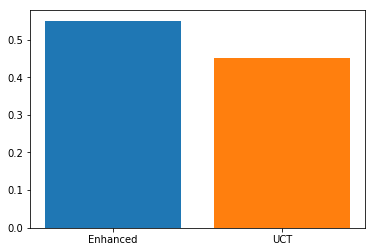

In [66]:
def test(*args):
    # Create our players
    player = TreeClassificationPlayer(0, 50)
    opponent = UCTPlayer(1, 50)
    
    # Run a full game
    game = play_game(player, opponent)
    
    return game.winner

import multiprocessing

pool = multiprocessing.Pool(4)
generator = list(range(20))

data = list(tqdm.tqdm_notebook(pool.imap(test, generator), total=len(generator)))
wins = sum(data) / len(data)
losses = 1 - wins

plt.bar(0, losses)
plt.bar(1, wins)
plt.xticks([0, 1], ["Enhanced", "UCT"]);

The enhacned model is signinficantly better (with p=95%)

The tree classifier has another output : the probability of the point being each class.
We can use this ability to weigh each action when selecting at random

In [67]:
class TreeClassificationProbabilityPlayer(UCTPlayer):    
    def default_policy(self, node):
        legal_actions = node.legal_actions
        assert len(legal_actions) != 0
        
        # Ask the predictor for class probabilities
        predictions = tree.predict_proba(node.view_from_current_player.reshape(1, -1))[0]
        
        # Set probability to 0 for the non legal actions
        
        weights = [
            p + 0.1 if i in legal_actions else 0
            for i, p in enumerate(predictions)
        ]
        
        return random.choices(range(6), weights=weights)[0]

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

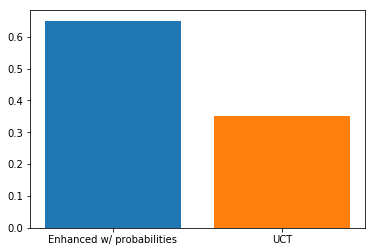

In [68]:
def test(*args):
    # Create our players
    player = TreeClassificationProbabilityPlayer(0, 50)
    opponent = UCTPlayer(1, 50)
    
    # Run a full game
    game = play_game(player, opponent)
    
    return game.winner

import multiprocessing

pool = multiprocessing.Pool(4)
generator = list(range(20))

data = list(tqdm.tqdm_notebook(pool.imap(test, generator), total=len(generator)))
wins = sum(data) / len(data)
losses = 1 - wins

plt.bar(0, losses)
plt.bar(1, wins)
plt.xticks([0, 1], ["Enhanced w/ probabilities", "UCT"]);

In [85]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

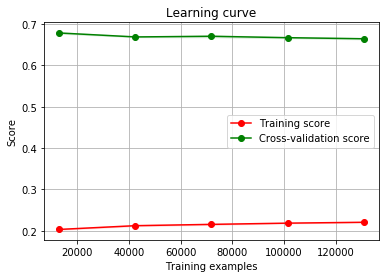

In [93]:
def custom(y, y_pred, *args):
    return np.mean(y != y_pred)

scorer = sklearn.metrics.make_scorer(custom)
plot_learning_curve(DecisionTreeClassifier(), "Learning curve", X, Yb, scoring=scorer);